In [1]:
import cudf
import dask_cudf
import cugraph
import cuspatial
import math
import geopy
import geopandas as gpd
from shapely.geometry import Point

DATA_DIR = "../data/"

In [2]:
def createCircleAroundWithRadius(lat, lon, radiusMiles):
    latArray = []
    lonArray = []

    for brng in range(0,360):
        lat2, lon2 = getLocation(lat,lon,brng,radiusMiles)
        latArray.append(lat2)
        lonArray.append(lon2)

    return lonArray,latArray


def getLocation(lat1, lon1, brng, distanceMiles):
    lat1 = lat1 * math.pi/ 180.0
    lon1 = lon1 * math.pi / 180.0
    #earth radius
    #R = 6378.1Km
    #R = ~ 3959 MilesR = 3959
    R = 3959

    distanceMiles = distanceMiles/R

    brng = (brng / 90)* math.pi / 2

    lat2 = math.asin(math.sin(lat1) * math.cos(distanceMiles) 
    + math.cos(lat1) * math.sin(distanceMiles) * math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(distanceMiles)
    * math.cos(lat1),math.cos(distanceMiles)-math.sin(lat1)*math.sin(lat2))

    lon2 = 180.0 * lon2/ math.pi
    lat2 = 180.0 * lat2/ math.pi

    return lat2, lon2

In [3]:
nodes_df = cudf.read_parquet(f'{DATA_DIR}us-nodes.parquet')
edges_df = cudf.read_parquet(f'{DATA_DIR}us-edges.parquet')

In [4]:
def get_updated_df(lat,lon, nodes_df):
    results = cuspatial.point_in_polygon(nodes_df.x, nodes_df.y, cudf.Series([0], index=["selection"]), [0], lat, lon)
    return nodes_df[results.selection]

def get_updated_edges(nodes, edges):
    indices = cudf.logical_and(
        edges.src.isin(nodes.vertex), edges_df.dst.isin(nodes.vertex),
    )
    return edges_df[indices]

def get_shortest_paths(edges_df, point_of_interest):
    G_gpu = cugraph.Graph()
    G_gpu.from_cudf_edgelist(edges_df, source='src', destination='dst', edge_attr='time')
    shortest_paths = cugraph.traversal.sssp(G_gpu, point_of_interest)
    shortest_paths = shortest_paths.drop('predecessor', axis=1)
    shortest_paths.columns = ['time', 'vertex']
    return shortest_paths

def get_nearest_node(gdf, point, x='x', y='y', osmid='osmid'):
    gdf = gdf
    gdf['point_y'] = point[0]
    gdf['point_x'] = point[1]
    gdf['distance'] = cuspatial.haversine_distance(gdf[y], gdf[x], 
                                                             gdf['point_y'], gdf['point_x'])
    mask = gdf['distance'] == gdf['distance'].min()
    nearest_node = gdf[mask][osmid].values[0]
    gdf.drop(['point_y', 'point_x', 'distance'], axis=1, inplace=True)
    return nearest_node

def get_polygons_for_travel_time(results, trip_times):
    for trip_time in trip_times:
        results['within_' + str(trip_time)] = 1.0 * (results['time'] < trip_time)

    # make the isochrone polygons
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        mask = results['within_' + str(trip_time)] == 1
        subset = results[mask].to_pandas()
        node_points = [Point((row['x'], row['y'])) for _, row in subset.iterrows()]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull  # TODO use cuspatial
        isochrone_polys.append(bounding_poly)
    return isochrone_polys

In [31]:
distanceInMiles = 60
trip_times = [5, 10, 15, 30, 60]

def get_nearest_polygons_from_selected_point(point_lat, point_lon, average_speed):
    lat, lon =  createCircleAroundWithRadius(point_lat, point_lon, distanceInMiles)
    nodes = get_updated_df(lat, lon, nodes_df)
    edges = get_updated_edges(nodes, edges_df)
    edges['time'] = edges['length'] / average_speed
    point_of_interest = get_nearest_node(nodes, point=(point_lat,point_lon), x='x', y='y', osmid='vertex')
    shortest_paths = get_shortest_paths(edges, point_of_interest)
    results = cudf.merge(shortest_paths, nodes[['vertex', 'y', 'x']], on='vertex', how='inner')
    polygons = get_polygons_for_travel_time(results, trip_times)
    del results, shortest_paths, edges, nodes
    return polygons

In [32]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="test_app")

In [33]:
address = geolocator.geocode("175 5th Avenue NYC")

In [34]:
%prun get_nearest_polygons_from_selected_point(address.latitude, address.longitude, 35)

         1285058 function calls (1267999 primitive calls) in 11.338 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    5.548    5.548    5.609    5.609 {cugraph.traversal.sssp_wrapper.sssp}
        8    2.010    0.251    2.010    0.251 {cudf._lib.sort.order_by}
        2    1.267    0.634    1.268    0.634 {cudf._lib.stream_compaction.drop_duplicates}
        8    0.458    0.057    0.460    0.057 {built-in method cudf._lib.join.join}
        1    0.337    0.337    0.351    0.351 gis.py:161(point_in_polygon)
       12    0.209    0.017    0.234    0.020 {cudf._lib.copying.gather}
       27    0.115    0.004    0.116    0.004 {cudf._lib.filling.sequence}
        2    0.090    0.045    3.908    1.954 column.py:822(isin)
        4    0.080    0.020    0.081    0.020 {method 'aggregate' of 'cudf._lib.groupby.GroupBy' objects}
   248024    0.046    0.000    0.077    0.000 {built-in method builtins.isinstance}
       64 

In [47]:
d = gpd.geodataframe.from_shapely(polygons)

In [49]:
crs = {'init': 'epsg:4326'}
polygon = gpd.GeoDataFrame(index=[0, 1,2,3, 4], crs=crs, geometry=d).reset_index(inplace=True)      

<AxesSubplot:>

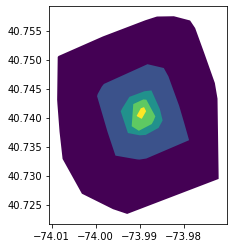

In [62]:
polygon.plot(column='index')